<a href="https://colab.research.google.com/github/NaveenTark/Reinforcement-Learning-with-CPP-and-Python/blob/main/Classical_RL/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# Define Environment
class GridworldMDP:
    def __init__(self, grid, start, goal, traps, obstacles, p_success=0.8, gamma=0.9):
        """
        Initialize Gridworld MDP.

        :param grid: (int, int) Grid size (rows, cols)
        :param start: (int, int) Starting position
        :param goal: (int, int) Goal position
        :param traps: List of (int, int) positions with trap rewards (-1)
        :param obstacles: List of (int, int) impassable positions
        :param p_success: Probability of moving in the intended direction
        :param gamma: Discount factor for future rewards
        """
        self.grid_size = grid

        # Validate initializations
        assert start != goal, "Start and goal positions cannot be the same."
        assert 0 <= start[0] < grid[0] and 0 <= start[1] < grid[1], "Invalid start position."
        assert 0 <= goal[0] < grid[0] and 0 <= goal[1] < grid[1], "Invalid goal position."
        assert all(0 <= trap[0] < grid[0] and 0 <= trap[1] < grid[1] for trap in traps), "Invalid trap position."
        assert all(0 <= obs[0] < grid[0] and 0 <= obs[1] < grid[1] for obs in obstacles), "Invalid obstacle position."
        assert 0 <= p_success <= 1, "Invalid success probability."
        assert 0 <= gamma <= 1, "Invalid discount factor."

        self.start = start
        self.goal = goal
        self.traps = set(traps)
        self.obstacles = set(obstacles)
        self.p_success = p_success
        self.gamma = gamma
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # UP, DOWN, LEFT, RIGHT
        self.reset()

    def reset(self):
        """Reset the agent to the start position."""
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        """
        Take a step in the environment.

        :param action: (int) Action index [0=UP, 1=DOWN, 2=LEFT, 3=RIGHT]
        :return: (new_state, reward, done)
        """
        if np.random.rand() < self.p_success:
            move = self.actions[action]  # Intended move
        else:
            move = self.actions[np.random.choice(4)]  # Random move

        new_pos = (self.agent_pos[0] + move[0], self.agent_pos[1] + move[1])

        # Check for out-of-bounds or obstacle
        if (new_pos[0] < 0 or new_pos[0] >= self.grid_size[0] or
            new_pos[1] < 0 or new_pos[1] >= self.grid_size[1] or
            new_pos in self.obstacles):
            new_pos = self.agent_pos  # Stay in place

        self.agent_pos = new_pos

        # Assign rewards
        if new_pos == self.goal:
            return new_pos, 1.0, True  # Goal reached
        elif new_pos in self.traps:
            return new_pos, -1.0, True  # Trap
        else:
            return new_pos, 0.0, False  # Neutral move

    def get_transitions(self, state, action):
      """
      Return a list of transitions for a given state and action.
      Each transition is a tuple: (next_state, reward, done, probability)
      This function computes all possible outcomes given the stochastic dynamics.
      """
      outcomes = {}
      # Intended move
      intended_move = self.actions[action]
      next_state = (state[0] + intended_move[0], state[1] + intended_move[1])
      if (next_state[0] < 0 or next_state[0] >= self.grid_size[0] or
          next_state[1] < 0 or next_state[1] >= self.grid_size[1] or
          next_state in self.obstacles):
          next_state = state  # Stay in place if move is invalid
      if next_state == self.goal:
          reward, done = 1.0, True
      elif next_state in self.traps:
          reward, done = -1.0, True
      else:
          reward, done = 0.0, False

      outcomes[next_state] = (reward, done, self.p_success)

      # Random moves (with probability (1 - p_success) equally divided among all actions)
      random_prob = (1 - self.p_success) / 4.0
      for rand_action in range(4):
          rand_move = self.actions[rand_action]
          rand_state = (state[0] + rand_move[0], state[1] + rand_move[1])
          if (rand_state[0] < 0 or rand_state[0] >= self.grid_size[0] or
              rand_state[1] < 0 or rand_state[1] >= self.grid_size[1] or
              rand_state in self.obstacles):
              rand_state = state  # Stay in place if invalid
          if rand_state == self.goal:
              rand_reward, rand_done = 1.0, True
          elif rand_state in self.traps:
              rand_reward, rand_done = -1.0, True
          else:
              rand_reward, rand_done = 0.0, False

          # If outcome already exists, add probability
          if rand_state in outcomes:
              prev_reward, prev_done, prev_prob = outcomes[rand_state]
              outcomes[rand_state] = (rand_reward, rand_done, prev_prob + random_prob)
          else:
              outcomes[rand_state] = (rand_reward, rand_done, random_prob)

      transitions = []
      for ns, (rew, done, prob) in outcomes.items():
          transitions.append((ns, rew, done, prob))
      return transitions
    def get_possible_actions(self, state):
        """Returns a list of valid actions from a given state."""
        actions = []
        for i, move in enumerate(self.actions):
            new_pos = (state[0] + move[0], state[1] + move[1])
            if (0 <= new_pos[0] < self.grid_size[0] and
                0 <= new_pos[1] < self.grid_size[1] and
                new_pos not in self.obstacles):
                actions.append(i)
        return actions

    def render(self):
        """Print the grid with the agent's position."""
        grid_display = np.full(self.grid_size, ".", dtype=str)
        grid_display[self.goal] = "G"
        for trap in self.traps:
            grid_display[trap] = "T"
        for obs in self.obstacles:
            grid_display[obs] = "#"
        grid_display[self.agent_pos] = "A"  # Agent

        for row in grid_display:
            print(" ".join(row))
        print()


In [26]:
GridWorld1 = GridworldMDP((4,4), (0,0), (3,3), [(3,2)], [(1,3),(2,1)],1,0.9)

In [27]:
GridWorld1.render()

A . . .
. . . #
. # . .
. . T G



In [39]:
# Q-learning parameters
alpha = 0.1          # Learning rate
epsilon = 0.1        # Exploration rate
num_episodes = 1000000  # Total episodes for training
max_steps = 100      # Maximum steps per episode

# Initialize Q-table with zeros
q_table= np.zeros((GridWorld1.grid_size[0], GridWorld1.grid_size[1], len(GridWorld1.actions)))

def choose_action(env,q_table,state):
    """
    Choose an action using epsilon-greedy strategy
    from the available valid actions at a given state.
    """
    if np.random.rand() < epsilon:
        # Explore: choose a random valid action
        possible_actions = env.get_possible_actions(state)
        return np.random.choice(possible_actions)
    else:
        # Exploit: choose the best action based on current Q-values
        row, col = state
        possible_actions = env.get_possible_actions(state)
        Q_vals = Q[row, col, possible_actions]
        # If there are multiple best actions, np.argmax returns the first one
        return possible_actions[np.argmax(Q_vals)]


def QLearning(env, q_table, num_episodes, discount_factor=0.9,
              initial_learning_rate=1e-3, min_epsilon=0.1, decay_factor=0.995):

  # Q-learning main loop
  for episode in range(num_episodes):
      state = env.reset()

      for step in range(max_steps):
          row, col = state

          # Select action using epsilon-greedy policy
          action = choose_action(env,q_table,state)

          # Take action in the environment
          next_state, reward, done = env.step(action)
          next_row, next_col = next_state

          # Q-learning update rule
          best_next_value = np.max(q_table[next_row, next_col, :])
          q_table[row, col, action] = q_table[row, col, action] + alpha * (reward + env.gamma * best_next_value - q_table[row, col, action])

          state = next_state

          if done:
              break

QLearning(GridWorld1,q_table,num_episodes)

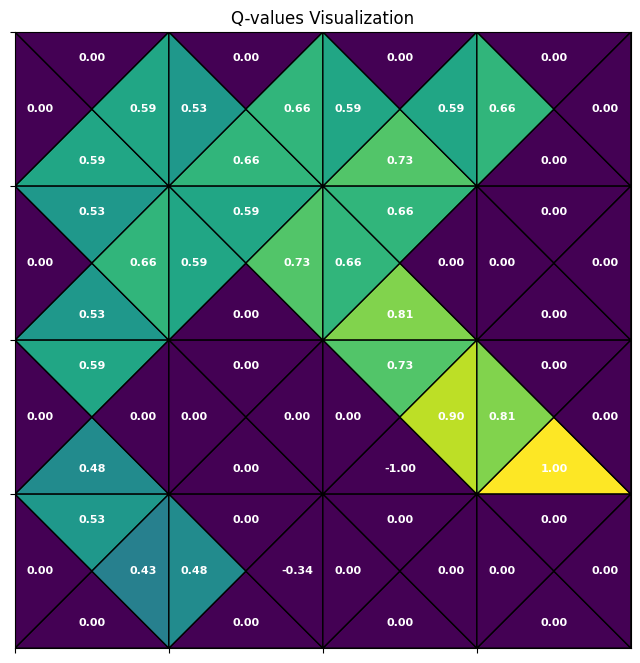

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def visualize_q_values(q_values):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(q_values.shape[1]))
    ax.set_yticks(np.arange(q_values.shape[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, q_values.shape[1])
    ax.set_ylim(0, q_values.shape[0])
    ax.invert_yaxis()  # Origin at top-left corner

    # Define action labels
    action_labels = ['Up', 'Down', 'Left', 'Right']

    # Iterate over each state in the grid
    for i in range(q_values.shape[0]):
        for j in range(q_values.shape[1]):
            # Coordinates for the center of the grid cell
            center_x, center_y = j + 0.5, i + 0.5
            # Define the vertices for the four triangles
            triangles = [
                [(center_x, center_y), (j, i), (j + 1, i)],  # Up
                [(center_x, center_y), (j, i + 1), (j + 1, i + 1)],  # Down
                [(center_x, center_y), (j, i), (j, i + 1)],  # Left
                [(center_x, center_y), (j + 1, i), (j + 1, i + 1)]   # Right
            ]
            # Plot each triangle
            for action, triangle in enumerate(triangles):
                polygon = patches.Polygon(triangle, closed=True,
                                           facecolor=plt.cm.viridis(q_values[i, j, action] / np.max(q_values)),
                                           edgecolor='k')
                ax.add_patch(polygon)
                # Annotate the triangle with the Q-value
                mid_x = np.mean([pt[0] for pt in triangle])
                mid_y = np.mean([pt[1] for pt in triangle])
                ax.annotate(f'{q_values[i, j, action]:.2f}', (mid_x, mid_y),
                            color='white', weight='bold', fontsize=8,
                            ha='center', va='center')

    plt.title('Q-values Visualization')
    plt.show()

visualize_q_values(q_table)

In [41]:
# Optimal Policy
action_mapping = {0: "UP", 1: "DOWN", 2: "LEFT", 3 : "RIGHT"}  # UP, DOWN, LEFT, RIGHT
print("Final policy as grid:")
grid_display = np.full(GridWorld1.grid_size, ".", dtype=str)

# Create a dictionary to store the policy:
policy = {}
for i in range(q_table.shape[0]):
    for j in range(q_table.shape[1]):
        state = (i, j)
        # Skip terminal and obstacle states:
        if state in GridWorld1.traps or state == GridWorld1.goal or state in GridWorld1.obstacles:
            policy[state] = "NAN"
        else:
            # Get the action with the highest Q-value for this state:
            best_action = np.argmax(q_table[i, j, :])
            policy[state] = action_mapping[best_action]  # Map action index to action label

# Update grid_display with the policy:
for state, action in policy.items():
    if action != "NAN":  # Skip terminal and obstacle states
        grid_display[state] = action
grid_display[GridWorld1.goal] = "G"  # Goal
for trap in GridWorld1.traps:
    grid_display[trap] = "T"  # Traps
for obs in GridWorld1.obstacles:
    grid_display[obs] = "#"  # Obstacles

# Print the grid:
for row in grid_display:
    print(" ".join(row))

Final policy as grid:
D D D L
R R D #
U # R D
U L T G
